In [52]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
%matplotlib inline

In [53]:
#Read Databases
precios = pd.read_csv('https://raw.githubusercontent.com/zaygb/Derivados/main/PRECIOS.csv')
costo_almacen = pd.read_csv('https://raw.githubusercontent.com/zaygb/Derivados/main/COSTOS_ALMACEN.csv')
curva_mxn = pd.read_csv('https://raw.githubusercontent.com/zaygb/Derivados/main/CURVAMXN.csv')
curva_usd = pd.read_csv('https://raw.githubusercontent.com/zaygb/Derivados/main/CURVAUSD.csv')
dividendos = pd.read_csv('https://raw.githubusercontent.com/zaygb/Derivados/main/DIVIDENDOS.csv')
dividendos_tasa = pd.read_csv('https://raw.githubusercontent.com/zaygb/Derivados/main/TASA_DIVIDENDOS.csv')


### Moneda Origen
Si el nombre de la empresa no termina en (USD) o (EUR) se asumira que es una empresa Mexicana, por lo que se usara la curva MXN y el precio se considerara en pesos mexicanos (MXN)

In [54]:
#Función para saber la moneda origen del subyacente (USD, MXN, EUR)
def origen_sub(Activo):
    if Activo.endswith('(USD)') or Activo.startswith('USD'): return 'USD'
    elif Activo.endswith('(EUR)') or Activo.startswith('EUR'): return 'EUR'
    else: return 'MXN'

### Manipulación de tablas
Se reordenan las tablas para poder realizar los calculos (solo correr codigo)

In [55]:
#Cambiar la columna Dates a tipo fecha
precios['Dates'] = pd.to_datetime(precios['Dates'], format= '%d/%m/%Y') #Precios
dividendos['Dates'] = pd.to_datetime(dividendos['Dates'], format= '%d/%m/%Y') #Dividendos
dividendos_tasa['Dates'] = pd.to_datetime(dividendos_tasa['Dates'], format= '%d/%m/%Y') #Dividendos Tasa
costo_almacen['Dates'] = pd.to_datetime(costo_almacen['Dates'], format= '%d/%m/%Y') #Costos Almacen


In [56]:
#Unpivot Tabla de Precios
precios_melt = precios.melt(id_vars='Dates', var_name='Activo', value_name='Precio')
precios_melt['Moneda_Origen'] = precios_melt['Activo'].apply(origen_sub)

In [57]:
Precios_y_Divisas = precios[['Dates','MXN/USD','USD/EUR','MXN/EUR']]
Precios_y_Divisas = pd.merge(precios_melt,Precios_y_Divisas)

In [58]:
#Unpivot Tablas de Curvas
curva_usd_melt = curva_usd.melt(id_vars='Node',var_name='Dates', value_name='Valor')
curva_usd_melt['Moneda_Origen'] = 'USD'
curva_mxn_melt = curva_mxn.melt(id_vars='Node',var_name='Dates', value_name='Valor')
curva_mxn_melt['Moneda_Origen'] = 'MXN'

In [59]:
#Unir Tablas de Curvas
curvas = pd.concat([curva_mxn_melt,curva_usd_melt], ignore_index=True)

#Convertir columna Dates a tipo fecha
curvas['Dates'] = pd.to_datetime(curvas['Dates'], format= '%d/%m/%Y')

### Funciones para calcular Precio justo de un Forward

#### Sin dividendos

In [60]:
def Precio_Forward_sd(St,r,T) : 
    F = round(St*(math.exp((r)*(T/360))),3)
    return F

#### Con dividendos

In [61]:
#Calcular I (Suma de los dividendos traidos a valor presente)
def Dividendos(dv, activo, fecha_apertura, fecha_vencimiento):
    #Filtrar por el activo usado
    dv = dv[['Dates', activo]]
    if origen_sub(activo) == 'USD':
        dv['Moneda_Origen'] = 'USD'
    elif origen_sub(activo) == 'EUR':
        dv['Moneda_Origen'] = 'EUR'
    else: dv['Moneda_Origen'] = 'MXN'

    #Filtrar tabla de dividendos entre las fechas dadas
    dv = dv[dv['Dates'] <= fecha_vencimiento]
    dv = dv[dv['Dates'] >= fecha_apertura]

    dv['Node'] = dv['Dates'].apply(lambda x: (x - fecha_apertura).days) 
    dv = pd.merge(dv,curvas, on = ['Dates', 'Node', 'Moneda_Origen'])
    
    dv['Div_Presente'] = dv.apply(lambda row: row[activo] * math.exp(-(row['Valor'] * row['Node'] / 360)), axis=1)
    I = dv['Div_Presente'].sum()
    return I


In [62]:
#Calcular el precio justo del forward restandole los dividendos
def Precio_Forward_cd(St,r,T,I) : 
    F = round((St-I)*(math.exp((r)*(T/360))),3)
    return F

#### Tasa de dividendos


In [63]:
#Tasa de dividendos d
def tasa(tab1,dv,activo):
    #Filtrar por el activo usado
    dv = dv[['Dates', activo]]
    tab1 = pd.merge(tab1, dv, on='Dates')
    tab1.rename(columns={activo: 'd'}, inplace=True)

    return tab1

In [64]:
#Calcular el precio justo del forward restandole los dividendos como tasa
def Precio_Forward_td(St,r,T,d) : 
    F = round((St)*(math.exp((r-d)*(T/360))),3)
    return F

#### Divisa

In [65]:
#Agregar curva de la moneda extranjera
def curva_extranjera(tab1, curvas, activo):
    moneda_extranjera=activo[-3:]
    curvas = curvas[curvas['Moneda_Origen']==moneda_extranjera] 
    curvas.rename(columns={'Moneda_Origen': 'Moneda_ext'}, inplace=True)
    curvas.rename(columns={'Valor': 'Valor_ext'}, inplace=True)
    tab1 = pd.merge(tab1, curvas, on=['Dates', 'Node'])
    return tab1

In [66]:
#Calcular el precio justo del forward de la divisa
def Precio_Forward_divisa(St,rloc,rext,T) : 
    F = round(St*(math.exp((rloc-rext)*(T/360))),3)
    return F

#### Commodities

In [67]:
#Calcular U (Suma de los costos de almacenamiento traidos a valor presente)
def Costos(cm, activo, fecha_apertura, fecha_vencimiento):
    #Filtrar por el activo usado
    cm = cm[['Dates', activo]]
    if origen_sub(activo) == 'USD':
        cm['Moneda_Origen'] = 'USD'
    elif origen_sub(activo) == 'EUR':
        cm['Moneda_Origen'] = 'EUR'
    else: cm['Moneda_Origen'] = 'MXN'

   #Filtrar tabla de dividendos entre las fechas dadas
    cm = cm[cm['Dates'] <= fecha_vencimiento]
    cm = cm[cm['Dates'] >= fecha_apertura]
    cm['Node'] = cm['Dates'].apply(lambda x: (x - fecha_apertura).days) 
    cm = pd.merge(cm,curvas, on = ['Dates', 'Node', 'Moneda_Origen'])
    cm['Div_Presente'] = cm.apply(lambda row: row[activo] * math.exp(-(row['Valor'] * row['Node'] / 360)), axis=1)
    U = cm['Div_Presente'].sum()
    return U

In [68]:
costo_almacen

,Dates,BIMBO,CEMEX,JOSECUERVO,FEMSA,TELEVISA,VOLARIS,MXN/USD,USD/EUR,MXN/EUR,IPC,S&P500 (USD),AMAZON (USD),ORO (USD)
0,2022-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,2022-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6,2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
7,2022-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8,2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
9,2023-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [69]:
ORO

,Dates,Activo,Precio,Moneda_Origen,Node,Valor,U
0,2022-01-03,ORO (USD),1801.45,USD,365,0.0315,44.024915
1,2022-01-04,ORO (USD),1814.60,USD,364,0.0320,44.030484
2,2022-01-05,ORO (USD),1810.44,USD,363,0.0323,44.035645
3,2022-01-06,ORO (USD),1791.16,USD,362,0.0325,44.040564
4,2022-01-07,ORO (USD),1796.55,USD,361,0.0324,44.045961
...,...,...,...,...,...,...,...
249,2022-12-28,ORO (USD),1804.35,USD,6,0.0515,0.000000
250,2022-12-29,ORO (USD),1814.91,USD,5,0.0515,0.000000
251,2022-12-30,ORO (USD),1824.02,USD,4,0.0517,0.000000
252,2023-01-02,ORO (USD),1824.02,USD,1,0.0516,0.000000


In [70]:
#Calcular el precio justo del forward sumandole los costos de almacenamiento
def Precio_Forward_comm(St,r,T,U) : 
    F = round((St+U)*(math.exp((r)*(T/360))),3)
    return F

### Funciones para calcular el valor de un Forward

#### General

In [71]:
def Valor_Forward(tab1, tipo_forward):
    F0 = tab1['Precio_Forward'].iloc[0]
    if tipo_forward == 'largo':
        tab1['Valor_Forward'] = tab1.apply(lambda row: (row['Precio_Forward']-F0) * math.exp(-(row['Valor'] * row['Node'] / 360)), axis=1)
    elif tipo_forward == 'corto': 
        tab1['Valor_Forward'] = tab1.apply(lambda row: (F0-row['Precio_Forward']) * math.exp(-(row['Valor'] * row['Node'] / 360)), axis=1)
    return tab1

### Función para calcular el valor diario de un forward dado:

In [85]:
def Forward_Diario(activo, fecha_apertura, fecha_vencimiento,tipo_activo, tipo_forward, cantidad):
    #Filtrar el activo
    tab1 = precios_melt[precios_melt['Activo']==activo]

    #Cambiar variables a tipo fecha
    fecha_apertura = datetime.strptime(fecha_apertura, '%d/%m/%Y')
    fecha_vencimiento = datetime.strptime(fecha_vencimiento, '%d/%m/%Y')

    #Filtrar tabla de precios entre las fechas dadas
    tab1 = tab1[tab1['Dates'] <= fecha_vencimiento]
    tab1 = tab1[tab1['Dates'] >= fecha_apertura]
    
    #Nodos
    tab1['Node'] = tab1['Dates'].apply(lambda x: (fecha_vencimiento - x).days)   
    ultimo_renglon = tab1.iloc[-1:]
    ultimo_renglon['Valor'] = ultimo_renglon['Precio']
    
    #Asignar un valor de la curva a cada fecha respecto a su nodo
    tab1 = pd.merge(tab1,curvas, on = ['Dates', 'Node', 'Moneda_Origen'])

    #Agregar ultimo renglon
    tab1 = pd.concat([tab1, ultimo_renglon]).reset_index(drop=True)

    #Calcular Precio justo del Forward
    if tipo_activo == 'sin_dividendos':
        tab1['Precio_Forward'] =  tab1.apply(lambda row: Precio_Forward_sd(row['Precio'], row['Valor'], row['Node']), axis=1)
    elif tipo_activo == 'con_dividendos':
        tab1['I'] =  tab1.apply(lambda row: Dividendos(dividendos, activo, row['Dates'], fecha_vencimiento), axis=1)
        tab1['Precio_Forward'] =  tab1.apply(lambda row: Precio_Forward_cd(row['Precio'],row['Valor'],row['Node'],row['I']), axis=1)
    elif tipo_activo == 'con_tasa_dividendos':
        tab1 = tasa(tab1,dividendos_tasa,activo)
        tab1['Precio_Forward'] = tab1.apply(lambda row: Precio_Forward_td(row['Precio'],row['Valor'],row['Node'],row['d']), axis=1)
    elif tipo_activo == 'divisa':
        tab1 = curva_extranjera(tab1, curvas, activo)
        tab1['Precio_Forward'] = tab1.apply(lambda row: Precio_Forward_divisa(row['Precio'],row['Valor'],row['Valor_ext'],row['Node']), axis=1)
    elif tipo_activo == 'commodities':
        tab1['U'] =  tab1.apply(lambda row: Costos(costo_almacen, activo, row['Dates'], fecha_vencimiento), axis=1)
        tab1['Precio_Forward'] =  tab1.apply(lambda row: Precio_Forward_comm(row['Precio'],row['Valor'],row['Node'],row['U']), axis=1)
    else: return print('Sintaxis en tipo_activo incorecta, revisar')

    #Calcular Valor del forward
    if tipo_forward != 'largo' and tipo_forward != 'corto':
        return print('Sintaxis en tipo_forward incorecta, revisar')
    else: Valor_Forward(tab1, tipo_forward)
   
    tab1['Valor_Forward'] = tab1['Valor_Forward']*cantidad
    
    if origen_sub(activo) == 'USD' and tipo_activo!='divisa':
        cambio = precios[['MXN/USD','Dates']]
        tab1 = pd.merge(tab1,cambio, on= 'Dates')
        tab1['Valor_Forward'] = tab1['Valor_Forward']*tab1['MXN/USD']
    elif origen_sub(activo) == 'EUR' and tipo_activo!='divisa': 
        cambio = precios[['MXN/EUR','Dates']]
        tab1 = pd.merge(tab1,cambio, on= 'Dates')
        tab1['Valor_Forward'] = tab1['Valor_Forward']*tab1['MXN/EUR']
    return tab1[['Dates','Valor_Forward']]

### Utilizar la función para calcular diferentes Forwards:
##### 1. activo: Nombre de la acción, divisa, commoditie o el activo subyacente correspondiente al forward (Ejemplo: BIMBO)
##### 2. fecha_apertura: Fecha en que se abre el contrato en formato dd/mm/aaaa (Ejemplo: 27/04/2001)
##### 3. fecha_vencimiento: Fecha en que se vence el contrato en formato dd/mm/aaaa (Ejemplo: 27/04/2001)
##### 4. tipo_activo: cualquiera de las siguientes opciones: 
            
            sin_dividendos
            con_dividendos
            con_tasa_dividendos
            divisa
            commodities

##### 5. tipo_forward: corto o largo

#### BIMBO

In [74]:
BIMBO = Forward_Diario('BIMBO','03/01/2022','03/01/2023','con_dividendos','largo', 1000000)

C:\Users\zayde\AppData\Local\Temp\ipykernel_19896\60146037.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimo_renglon['Valor'] = ultimo_renglon['Precio']


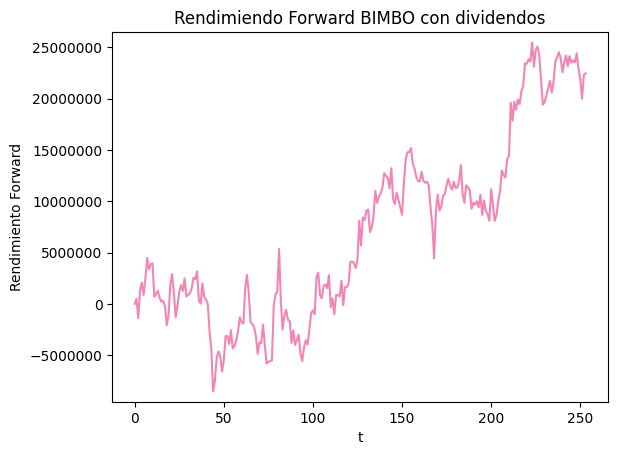

In [75]:
BIMBO['Valor_Forward'].plot.line(color= '#f484b6')
plt.xlabel('t')
plt.ylabel('Rendimiento Forward')
plt.title('Rendimiendo Forward BIMBO con dividendos')
max_ylim = max(BIMBO['Valor_Forward'])+1000000
min_ylim = min(BIMBO['Valor_Forward'])-1000000
plt.ylim(min_ylim,max_ylim)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### CEMEX

In [76]:
CEMEX = Forward_Diario('CEMEX','03/01/2022','03/01/2023','sin_dividendos','largo',1000000)

C:\Users\zayde\AppData\Local\Temp\ipykernel_19896\60146037.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimo_renglon['Valor'] = ultimo_renglon['Precio']


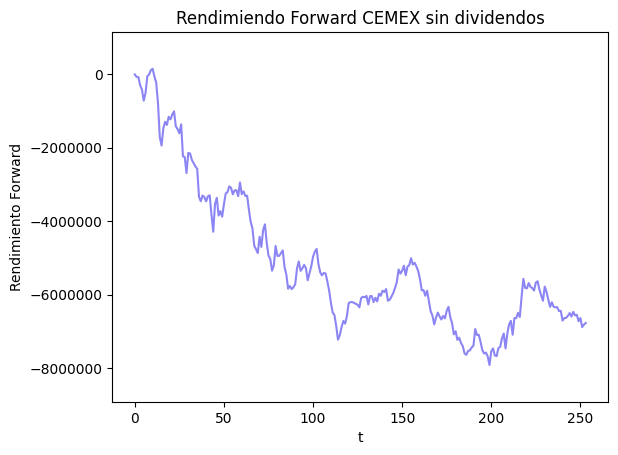

In [77]:
CEMEX['Valor_Forward'].plot.line(color= '#8c85f4')
plt.xlabel('t')
plt.ylabel('Rendimiento Forward')
plt.title('Rendimiendo Forward CEMEX sin dividendos')
max_ylim = max(CEMEX['Valor_Forward'])+1000000
min_ylim = min(CEMEX['Valor_Forward'])-1000000
plt.ylim(min_ylim,max_ylim)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### MXN/USD

In [78]:
MXN_USD = Forward_Diario('MXN/USD','03/01/2022','03/01/2023','divisa','largo',1000000)

C:\Users\zayde\AppData\Local\Temp\ipykernel_19896\60146037.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimo_renglon['Valor'] = ultimo_renglon['Precio']
C:\Users\zayde\AppData\Local\Temp\ipykernel_19896\2629356872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curvas.rename(columns={'Moneda_Origen': 'Moneda_ext'}, inplace=True)
C:\Users\zayde\AppData\Local\Temp\ipykernel_19896\2629356872.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

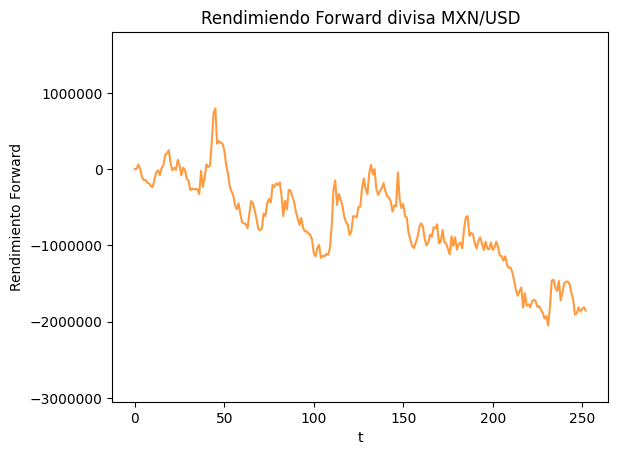

In [79]:
MXN_USD['Valor_Forward'].plot.line(color= '#ff9a3e')
plt.xlabel('t')
plt.ylabel('Rendimiento Forward')
plt.title('Rendimiendo Forward divisa MXN/USD')
max_ylim = max(MXN_USD['Valor_Forward'])+1000000
min_ylim = min(MXN_USD['Valor_Forward'])-1000000
plt.ylim(min_ylim,max_ylim)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### S&P500

In [80]:
SP500 = Forward_Diario('S&P500 (USD)','03/01/2022','03/01/2023','con_tasa_dividendos','largo',1000000)

C:\Users\zayde\AppData\Local\Temp\ipykernel_19896\60146037.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimo_renglon['Valor'] = ultimo_renglon['Precio']


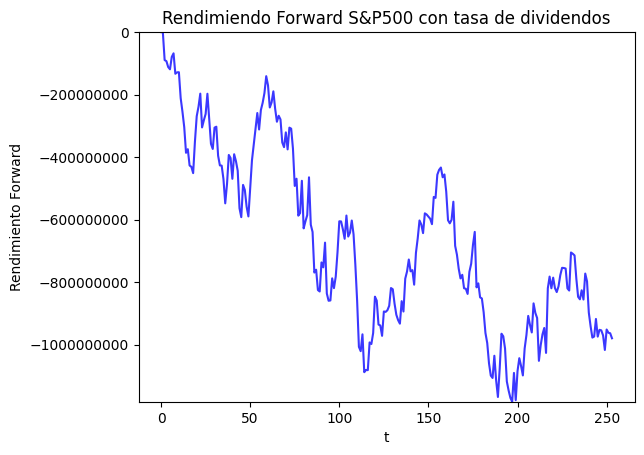

In [81]:
SP500['Valor_Forward'].plot.line(color= '#3b38ff')
plt.xlabel('t')
plt.ylabel('Rendimiento Forward')
plt.title('Rendimiendo Forward S&P500 (en pesos Mexicanos) con tasa de dividendos')
max_ylim = max(SP500['Valor_Forward'])+10000
min_ylim = min(SP500['Valor_Forward'])-10000
plt.ylim(min_ylim,max_ylim)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### ORO 

In [82]:
ORO = Forward_Diario('ORO (USD)','03/01/2022','03/01/2023','commodities','largo',1000000)

C:\Users\zayde\AppData\Local\Temp\ipykernel_19896\60146037.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ultimo_renglon['Valor'] = ultimo_renglon['Precio']


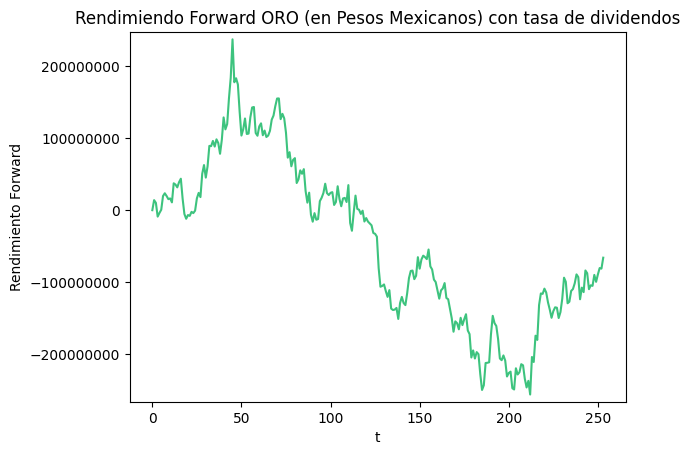

In [83]:
ORO['Valor_Forward'].plot.line(color= '#3dc37e')
plt.xlabel('t')
plt.ylabel('Rendimiento Forward')
plt.title('Rendimiendo Forward ORO (en Pesos Mexicanos) con tasa de dividendos')
max_ylim = max(ORO['Valor_Forward'])+100000000
min_ylim = min(ORO['Valor_Forward'])-100000000
plt.ylim(min_ylim,max_ylim)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [84]:
#Sin Dividendos
#tab1['Precio_Forward'] =  tab1.apply(lambda row: Precio_Forward_sd(row['Precio'], row['Valor'], row['Node']), axis=1)
#Con Dividendos
#tab1['I'] =  tab1.apply(lambda row: Dividendos(dividendos, activo, row['Dates'], fecha_vencimiento), axis=1)
#tab1['Precio_Forward'] =  tab1.apply(lambda row: Precio_Forward_cd(row['Precio'],row['Valor'],row['Node'],row['I']), axis=1)
#Con Tasa de Dividendos
#tab1 = tasa(tab1,dividendos_tasa,activo)
#tab1['Precio_Forward'] = tab1.apply(lambda row: Precio_Forward_td(row['Precio'],row['Valor'],row['Node'],row['d']), axis=1)
#Divisa 
#tab1 = curva_extranjera(tab1, curvas, activo)
#tab1['Precio_Forward'] = tab1.apply(lambda row: Precio_Forward_divisa(row['Precio'],row['Valor'],row['Valor_ext'],row['Node']), axis=1)
#Commodities
#tab1['U'] =  tab1.apply(lambda row: Costos(costo_almacen, 'ORO (USD)', row['Dates'], fecha_vencimiento), axis=1)
#tab1['Precio_Forward'] =  tab1.apply(lambda row: Precio_Forward_comm(row['Precio'],row['Valor'],row['Node'],row['U']), axis=1)


